In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform

In [33]:
mu_prior = 20 # Mean of gaussian prior
sigma_prior = 100 # Variance of gaussian prior

prior = norm(mu_prior, sigma_prior)
sigma_epsilon = 2 # Variance of observation noise
noise = norm(0, sigma_epsilon)

class h_kernel(object):
    def __init__(self, A=5):
        self.A = A
        self.d_theta = A
    def __call__(self, theta):
        return self.A * theta


h = h_kernel(A=5)

def y_obv(theta, h=h, noise=noise):
    obv = h(theta) + noise.rvs(1)
    return obv[0]



In [34]:
def get_sigma(mu_old, sigma_old, sigma_epsilon=sigma_epsilon, h=h):
    J = h.d_theta
    left_term = 1 / sigma_old
    right_term = ((J**2) * mu_old) / sigma_epsilon

    return 1 / (left_term + right_term)

def get_mu(mu_old, sigma_current, y, sigma_epsilon=sigma_epsilon, 
           h=h, mu_prior=mu_prior, sigma_prior=sigma_prior):
    J = h.d_theta
    left_term = ((J * mu_old) * (y - h(mu_old))) / sigma_epsilon
    right_term = (mu_prior - mu_old) / sigma_prior
    
    return mu_old + sigma_current * (left_term + right_term)


In [35]:
theta_true = 3
y = y_obv(theta_true)

mu_list, sigma_list = [mu_prior], [sigma_prior]
mu_i, sigma_i = mu_prior, sigma_prior
for idx in range(1000):
    #print(idx, end=' ')
    sigma_i = get_sigma(mu_i, sigma_i)
    mu_i = get_mu(mu_i, sigma_i, y)

    mu_list.append(mu_i)
    sigma_list.append(sigma_i)
    

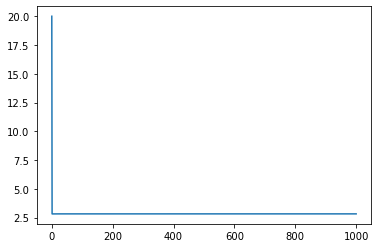

In [36]:
plt.plot(mu_list)